# Imports, Drive and GPU

In [ ]:
import pandas as pd # dataframes
import numpy as np # vectors and matrixes
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold # cross-validation
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit # separate train and test sets
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns # for confusion matrix
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt # plots
from sklearn.preprocessing import MinMaxScaler # normalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
from statistics import mean, stdev
import math
from scipy.ndimage import zoom # resize scans and attention maps
import copy
from keras import Model # intermediate layer (fature extraction)
# eliminate ramdomness to get reproducible results
import os # to create directories
os.environ['PYTHONHASHSEED']=str(7)
import random
random.seed(7)
from numpy.random import seed
seed(7)
tf.random.set_seed(7)
# to compute elapsed time of training
import time 
from datetime import timedelta
from tensorflow.keras.optimizers import SGD # to select sgd optimizer
from requests import get # to get this Google Colab file name
from tensorflow.keras.optimizers import Adam, SGD
import collections # for verifies
import shutil # to move files from directories
from sklearn.utils.class_weight import compute_class_weight
import json # for serialization
from contextlib import redirect_stdout # to redirect the standard output to a file (print model summary)

In [ ]:
from google.colab import drive, files # to use Google Drive
drive.flush_and_unmount()
drive.mount('/content/drive/') # connect to Google Drive
root_path = '/content/drive/My Drive/dataset' # change directory to my Google Drive
#root_path = 'G:\My Drive\dataset' # change directory to my device's database

Create directory for model metrics

In [ ]:
model_name = '/ResAtt/'+get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
model_name = model_name[:len(model_name)-6]
model_name = model_name.replace('%20', ' ')
print(model_name)
if not os.path.exists(root_path+'/Models_metrics'+ model_name):
    os.makedirs(root_path+'/Models_metrics'+ model_name)

Save GPU name

In [ ]:
if os.path.isfile('/gpu_name.txt'):
  print('exists in the destination path!')
  os.remove('/gpu_name.txt')
!nvidia-smi -L >> gpu_name.txt
if os.path.isfile(root_path+'/Models_metrics'+ model_name+'/gpu_name.txt'):
  print('exists in the destination path!')
  os.remove(root_path+'/Models_metrics'+ model_name+'/gpu_name.txt')
shutil.move('gpu_name.txt', root_path+'/Models_metrics'+ model_name)

# Setting Scan IDs, Subjects IDs and Scan Labels

scan_ids - Identification of each scan

labels - dictionary (key - scan ID; value - ground truth label)

subject_id - dictionary (key - scan ID; value - subject id)

In [ ]:
# set a list with all the scan ids possible
task = "NC vs AD" # ("NC vs AD" "AD vs MCI" "NC vs MCI" "NC vs MCI vs AD")

In [ ]:
data_augmentation = 0
if data_augmentation == 1:
  pet_source = '/PETs_numpy_data_augmentation'
else:
  pet_source = '/PETs_numpy'

In [ ]:
# load labels
labels = np.load(root_path + pet_source + '/Labels/labels.npy', allow_pickle='TRUE')
labels = labels.item()
# load subject ids
subject_id = np.load(root_path + pet_source + '/Subject_id/subject_id.npy', allow_pickle='TRUE')
subject_id = subject_id.item() # it is a dictionary

In [ ]:
nr_classes = 2
if task == "NC vs AD":
  # remove MCI information
  labels = { key: val for key, val in labels.items() if val != 1}
  scan_ids = list(labels.keys())
  subject_id = { key: val for key, val in subject_id.items() if key in scan_ids }
  # the class of AD is represented by nr 2, but we have to set it to 1 to be adapted for the model
  labels = {x: 1 if labels[x] == 2 else labels[x] for x in labels }
  target_classes = ['NC', 'AD']
elif task == "AD vs MCI":
  # remove NC information
  labels = { key: val for key, val in labels.items() if val != 0}
  scan_ids = list(labels.keys())
  subject_id = { key: val for key, val in subject_id.items() if key in scan_ids }
  # the class of AD is represented by nr 2, but we have to set it to 0 to be adapted for the model
  labels = {x: 0 if labels[x] == 2 else labels[x] for x in labels }
  target_classes = ['AD', 'MCI']
elif task == "NC vs MCI":
  # remove AD information
  labels = { key: val for key, val in labels.items() if val != 2}
  scan_ids = list(labels.keys())
  subject_id = { key: val for key, val in subject_id.items() if key in scan_ids }
  target_classes = ['NC', 'MCI']
elif task == "NC vs MCI vs AD":
  scan_ids = list(labels.keys())
  nr_classes = 3
  target_classes = ['NC', 'MCI', 'AD']

# list with all the labels, alternative to dictionary (needed sometimes)
labels_list = [ labels[id] for id in scan_ids ]
# list with all the subjects ids, alternative to dictionary (needed sometimes)
subject_id_list = [ subject_id[id] for id in scan_ids  ]

# Visualization

Auxilary function to transform from 2D coordinates to 1D and vice versa

In [ ]:
def coordinates_transform(point_vector_form):
  fixation_image = np.zeros(128*128)
  fixation_image[point_vector_form] = 1
  fixation_image = fixation_image.reshape(128, 128)
  coord_point = np.nonzero(fixation_image)
  return coord_point

def coordinates_untransform(point_x, point_y):
  if 0 <= point_x <= 127 and 0 <= point_y <= 127: 
    pt = 128*point_x+point_y
    return pt
  else:
    return False

In [ ]:
# plot the scan
def show_scan_plot(scan, slice_nr):
  one_slice_2d = scan[:,:,slice_nr] # array with one slice of a single patient
  plt.imshow(one_slice_2d, cmap='jet')
  plt.colorbar()

Plot a slice of a scan with the corresponding fixations on top

In [ ]:
# plot the fixations on top of the scan
def show_scan_with_fixations(allData, slice_nr, scan_index, save):

  if allData.at[scan_index, 'Has Fix'] == 0 or allData.at[scan_index, 'Fixations'][slice_nr] == []: 
    print("There are no fixations for slice number ", slice_nr, " of scan on row ", scan_index)
    return

  print("Subject ", allData.at[scan_index, 'Subject ID'])
  print("Fixation points ", allData.at[scan_index, 'Durations'][slice_nr])

  one_slice_2d = copy.deepcopy(allData.at[scan_index, 'Scan'][:,:,slice_nr]) # array with one slice of a single patient
  
  plt.imshow(one_slice_2d, cmap='jet')
  plt.colorbar()

  locations = allData.at[scan_index, 'Fixations'][slice_nr]
  coord = coordinates_transform(locations)
  plt.scatter(coord[0], coord[1])
  
  if save == "save":
    plt.savefig(f"/content/drive/My Drive/plots/scan_fixations_{allData.at[scan_index, 'Class']}_{slice_nr}_{allData.at[scan_index, 'Subject ID']}.pdf", 
              bbox_inches ="tight")
  
  #plt.show() 

# Verification of correct process of stratified cross-validation (To use when programming)

Print the number of scans of a subject in the train and test dataset

In [ ]:
import collections
def print_scans_of_the_same_subject(subject_id, train_scans, test_scans):
  subjects_train = [ subject_id[scan] for scan in train_scans ]
  print("subject ", subject_id, " has ", collections.Counter(subjects_train), " in the train dataset")

  subjects_test = [ subject_id[scan] for scan in test_scans ]
  print("subject ", subject_id, " has ", collections.Counter(subjects_test), " in the test dataset")

In [ ]:
def verify_veracity(index, subject_id_list, scan_ids, labels_list):
  print("subject id ", subject_id_list[index])
  print("scan ", scan_ids[index])
  print("label ", labels_list[index])

Print list of subjects IDs for both classes (there cannot be an overlap)

In [ ]:
def verify_common_subjects(subject_id, train_scans, test_scans):
  subjects_train = [ subject_id[scan] for scan in train_scans ]
  print(subjects_train)
  subjects_test = [ subject_id[scan] for scan in test_scans ]
  print(subjects_test)
  common_items = [ item for item in subjects_test if item in subjects_train ]
  print(common_items)

Check the porportion of both classes in the train and test set

In [ ]:
def verify_proportions(labels, train, test):
  train_total = 0
  train_count_class1 = 0
  train_count_class2 = 0

  for scan_id in train:
    train_total +=1
    if labels[scan_id] == 0:
      train_count_class1 +=1
    else:
      train_count_class2 +=1

  print("Train class1: ", round(train_count_class1/train_total, 2) ,"class2: ", round(train_count_class2/train_total, 2))

  test_total = 0
  test_count_class1 = 0
  test_count_class2 = 0

  for scan_id in test:
    test_total +=1
    if labels[scan_id] == 0:
      test_count_class1 +=1
    else:
      test_count_class2 +=1

  print("Test class1: ", round(test_count_class1/test_total, 2) ,"class2: ", round(test_count_class2/test_total, 2))

# Residual Attention module

Adapted to 3D from

https://github.com/qubvel/residual_attention_network/blob/master/models/models.py

Another implementation in keras, but not used

https://github.com/deontaepharr/Residual-Attention-Network/blob/3d0f683f5219bf0f8d069aaed7f60a60cad29bfe/Code/ResidualAttentionNetwork.py 



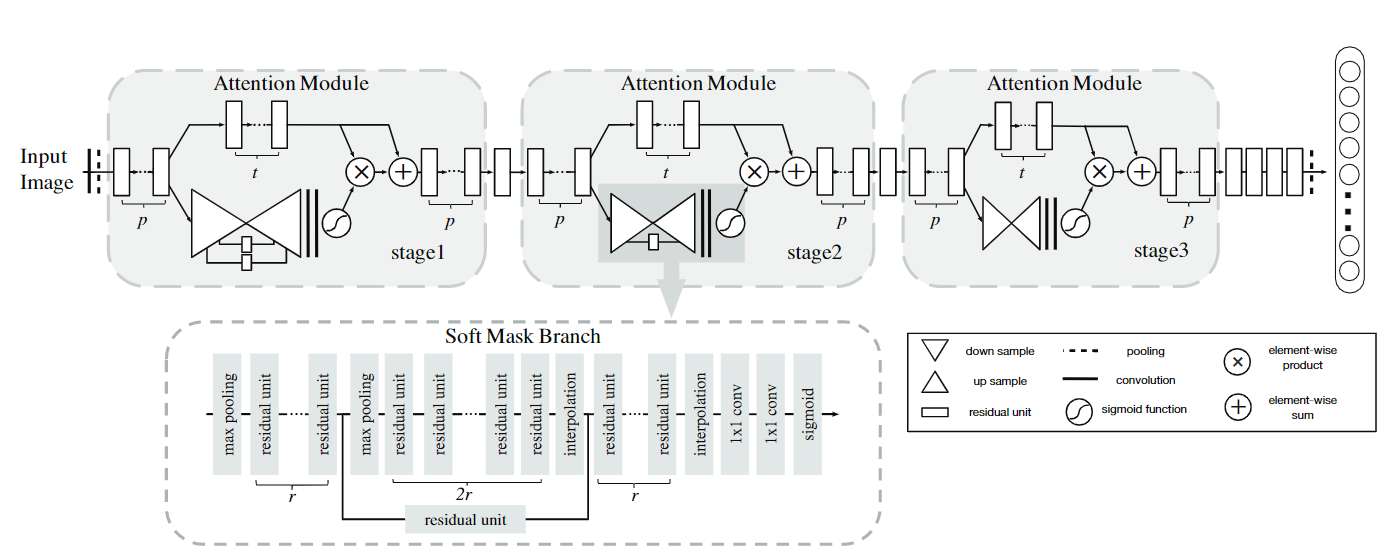

In [ ]:
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import UpSampling3D
from keras.layers import Activation
from keras.layers import MaxPool3D
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Lambda


def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3, 3), stride=1):
    """
    full pre-activation residual block
    https://arxiv.org/pdf/1603.05027.pdf
    """
    if output_channels is None:
        output_channels = input.get_shape()[-1]
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride, stride)

    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv3D(input_channels, (1,1,1))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(input_channels, kernel_size, padding='same', strides=stride)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(output_channels, (1,1,1), padding='same')(x)

    if input_channels != output_channels or stride != 1:
        input = Conv3D(output_channels, (1,1,1), padding='same', strides=strides)(input)

    x = Add()([x, input])
    return x

def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):
    """
    attention block
    https://arxiv.org/abs/1704.06904
    """

    p = 1
    t = 2
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1]
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch

    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool3D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)
        # print ('skip shape:', output_skip_connection.get_shape())

        ## down sampling
        output_soft_mask = MaxPool3D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

            ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling3D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling3D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv3D(input_channels, (1, 1, 1))(output_soft_mask)
    output_soft_mask = Conv3D(input_channels, (1, 1, 1))(output_soft_mask)
    output_soft_mask = Activation('sigmoid')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output

# ResNet 3D from Jihong Ju

3D ResNet that accepts as input 3D arrays with multiple channels. PET scans are 3D arrays with one channel.

This code was retrived from https://github.com/JihongJu/keras-resnet3d/blob/master/resnet3d/resnet3d.py with minor adaptations.

In [ ]:
from __future__ import (
    absolute_import,
    division,
    print_function,
    unicode_literals
)
import six
import math
from math import ceil
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from tensorflow.keras.layers import (
    Conv3D,
    AveragePooling3D,
    MaxPooling3D
)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


## Resnet 3D architecture

def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS, momentum=0.99)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault(
        "kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        conv = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f

def _bn_relu_conv3d(**conv_params):
    """Helper to build a  BN -> relu -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer",
                                                "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        block = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(activation)
        return block
    return f


def _shortcut3d(input, residual):
    """3D shortcut to match input and residual and merges them with "sum"."""
    stride_dim1 = math.ceil(int(input.shape[DIM1_AXIS]) \
        / int(residual.shape[DIM1_AXIS]))
    stride_dim2 = math.ceil(int(input.shape[DIM2_AXIS]) \
        / int(residual.shape[DIM2_AXIS]))
    stride_dim3 = math.ceil(int(input.shape[DIM3_AXIS]) \
        / int(residual.shape[DIM3_AXIS]))
    equal_channels = int(residual.shape[CHANNEL_AXIS]) \
        == int(input.shape[CHANNEL_AXIS])

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 \
            or not equal_channels:
        shortcut = Conv3D(
            filters=int(residual.shape[CHANNEL_AXIS]),
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return add([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(filters=filters, strides=strides,
                                   kernel_regularizer=kernel_regularizer,
                                   is_first_block_of_first_layer=(
                                       is_first_layer and i == 0)
                                   )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(filters=filters, kernel_size=(3, 3, 3),
                           strides=strides, padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer
                           )(input)
        else:
            conv1 = _bn_relu_conv3d(filters=filters,
                                    kernel_size=(3, 3, 3),
                                    strides=strides,
                                    kernel_regularizer=kernel_regularizer
                                    )(input)

        residual = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(filters=filters, kernel_size=(1, 1, 1),
                              strides=strides, padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer
                              )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(filters=filters, kernel_size=(1, 1, 1),
                                       strides=strides,
                                       kernel_regularizer=kernel_regularizer
                                       )(input)

        conv_3_3 = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_1_1)
        residual = _bn_relu_conv3d(filters=filters * 4, kernel_size=(1, 1, 1),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_3_3)

        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        print("here CHANNELS last")
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError("Input shape should be a tuple "
                             "(conv_dim1, conv_dim2, conv_dim3, channels) "
                             "for tensorflow as backend or "
                             "(channels, conv_dim1, conv_dim2, conv_dim3) "
                             "for theano as backend")

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(filters=64, kernel_size=(7, 7, 7),
                                strides=(2, 2, 2),
                                kernel_regularizer=l2(reg_factor)
                                )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2),
                             padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(block_fn, filters=filters,
                                      kernel_regularizer=l2(reg_factor),
                                      repetitions=r, is_first_layer=(i == 0)
                                      )(block)
            if i != len(repetitions)-1:
              block = attention_block(block, encoder_depth=len(repetitions)-1-i)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(pool_size=(int(block.shape[DIM1_AXIS]),
                                            int(block.shape[DIM2_AXIS]),
                                            int(block.shape[DIM3_AXIS])),
                                 strides=(1, 1, 1))(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="softmax",
                          kernel_regularizer=l2(reg_factor))(flatten1)
        else:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="sigmoid",
                          kernel_regularizer=l2(reg_factor))(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2,2,2,2], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_34(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 34."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [3, 4, 6, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_50(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 50."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 6, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_101(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 101."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 23, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 8, 36, 3], reg_factor=reg_factor)

# Data Generator

All data does not fit in memory during training, therefore a data generator is used. An instance of this data generator transfers to memory a small amount of samples each time, so the model can train with that small amount of samples. In the next iteration, transfers the next set of samples and so on.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(128,128,64), n_channels=1,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,:,:,0:60] = np.load(root_path + pet_source + '/python_normalized_reshaped/' + str(ID) + '.npy')

            # Store class
            y[i] = self.labels[ID]

        if self.n_classes > 1:
          y = tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

        return X, y

# Testing Metrics

Metrics: accuracy, confusion matrix, sensistivity, specificity, ROC, AUC

In [ ]:
# only for multiclass classification
def plot_ROC_AUC_multiclass(y_true,  y_pred, iteration):

  # roc curve for classes
  fpr = {}
  tpr = {}

  for i in range(nr_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true, y_pred, pos_label=i)
  
  y_true = label_binarize(y_true, classes=[0, 1, 2])
  y_pred = label_binarize(y_pred, classes=[0, 1, 2])
  auc = roc_auc_score(y_true, y_pred, multi_class="ovr", average=None)
      
  # plotting
  plt.rcParams.update(plt.rcParamsDefault) # reset plot configurations
  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=target_classes[0]+' vs Rest'+" | AUC = %0.2f" % auc[0])
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=target_classes[1]+' vs Rest'+" | AUC = %0.2f" % auc[1])
  plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label=target_classes[2]+' vs Rest'+" | AUC = %0.2f" % auc[2])
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='lower right')
  plt.savefig(f"{root_path}/Models_metrics{model_name}/ROC_AUC_{iteration}.pdf", bbox_inches ="tight")
  plt.show()

In [ ]:
# only for binary classification
def plot_ROC_AUC(y_true,  y_pred, auc_metric, iteration):
  fpr, tpr, _ = roc_curve(y_true,  y_pred)
  auc = roc_auc_score(y_true, y_pred)
  auc_metric.append(auc)
  
  plt.rcParams.update(plt.rcParamsDefault) # reset plot configurations

  # plot
  plt.figure()
  plt.plot(fpr, tpr, color="darkorange", lw=2, 
           label="AUC = %0.2f" % auc)
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.savefig(f"{root_path}/Models_metrics{model_name}/ROC_AUC_{iteration}.pdf", bbox_inches ="tight")
  plt.show()

Plot confusion matrix and accuracy

In [ ]:
def conf_matrix(y_true, y_pred, test_acc, iteration):
  c_m = confusion_matrix(y_true, y_pred)

  # compute accuracy
  test_acc.append(round(np.trace(c_m)/c_m.sum(), 4)*100)
  print("Test accuracy for every iteration ", test_acc)

  cm = c_m.astype('float') / c_m.sum(axis=1)[:,None] # normalize
  cm = cm.round(2)
  cm = pd.DataFrame(cm, index = target_classes, columns = target_classes)

  #plot
  plt.figure(figsize = (4,4))
  sns.set(font_scale=1.4) # for label size
  hm = sns.heatmap(cm, annot=True, cmap = "Blues", annot_kws={"size": 25}, cbar=False)
  hm.set_xlabel("Predicted Labels")
  hm.set_ylabel("Actual Labels")
  plt.savefig(f"{root_path}/Models_metrics{model_name}/conf_matrix_{iteration}.pdf", bbox_inches ="tight")
  plt.show()
  return c_m

Given a confusion matrix compute sensitivity and specificity.

In [ ]:
def compute_sen_spec(cm, sen_metric, spec_metric):
  sen = cm[1][1] / (cm[1][1]+cm[1][0])
  spec = cm[0][0] / (cm[0][0]+cm[0][1])
  sen_metric.append(sen)
  spec_metric.append(spec)
  print("sensitivity ", round(sen,4)*100, " %")
  print("specificity ", round(spec,4)*100, " %")

Agloremation of all the metrics in one function

In [ ]:
def metrics(y_pred_orig, y_true, test_metrics, iteration):
  # metrics: acc, confusion matrix, sen, spec, ROC, AUC
  if nr_classes == 3:
    y_pred = list(np.argmax(y_pred_orig, axis=1))
    print(classification_report(y_true, y_pred, target_names=target_classes))
    test_metrics['f1'].append(round(f1_score(y_true, y_pred), 2))
    print("f1-score ", test_metrics['f1'])
    conf_matrix(y_true, y_pred, test_metrics['acc'], iteration)
    y_pred_orig = [item for sublist in y_pred_orig for item in sublist]
    plot_ROC_AUC_multiclass(y_true,  y_pred_orig, iteration)  
  else:
    y_pred = list(np.argmax(y_pred_orig, axis=1))
    print(classification_report(y_true, y_pred, target_names=target_classes))
    test_metrics['f1'].append(round(f1_score(y_true, y_pred), 2))
    print("f1-score ", test_metrics['f1'])
    c_m = conf_matrix(y_true, y_pred, test_metrics['acc'], iteration)
    compute_sen_spec(c_m, test_metrics['sen'], test_metrics['spec'])
    plot_ROC_AUC(y_true, y_pred_orig[:,1], test_metrics['auc'], iteration)

In [ ]:
def show_means_metrics(test_metric):
  test_means = {'acc': {}, 'f1': {}, 'sen': {}, 'spec': {}, 'auc': {}}
  test_means['acc']['avg'] = round(mean(test_metric['acc']),4)
  test_means['acc']['std'] = round(stdev(test_metric['acc']), 4)
  print("Mean test accuracy ", test_means['acc']['avg'])
  print("Standard deviation accuracy ", test_means['acc']['std'])

  test_means['f1']['avg'] = round(mean(test_metric['f1']), 4)
  test_means['f1']['std'] = round(stdev(test_metric['f1']), 4)
  print("Mean test f1_score ", test_means['f1']['avg'])
  print("Standard deviation f1_score ", test_means['f1']['std'])

  test_means['sen']['avg'] = round(mean(test_metric['sen']), 4)
  test_means['sen']['std'] = round(stdev(test_metric['sen']), 4)
  print("Mean test sensitivity ", test_means['sen']['avg'])
  print("Standard deviation sensitivity ", test_means['sen']['std'])

  test_means['spec']['avg'] = round(mean(test_metric['spec']), 4)
  test_means['spec']['std'] = round(stdev(test_metric['spec']), 4)
  print("Mean test specificity ", test_means['spec']['avg'])
  print("Standard deviation specificity ", test_means['spec']['std'])

  test_means['auc']['avg'] = round(mean(test_metric['auc']), 4)
  test_means['auc']['std'] = round(stdev(test_metric['auc']), 4)
  print("Mean test AUC ", test_means['auc']['avg'])
  print("Standard deviation AUC ", test_means['auc']['std'])

  return test_means

# Training parameters



Training of the netork with cross-validation. Several validations were made for different hyperparameters, like batch size, nr of layers, normalization block's momentum.

In [ ]:
# Parameters
params = {'dim': (128,128,64),
          'batch_size': 16,
          'n_classes': nr_classes,
          'n_channels': 1,
          'shuffle': False}

params_test = {'dim': (128,128,64),
          'batch_size': 1,
          'n_classes': nr_classes,
          'n_channels': 1,
          'shuffle': False}

Plots of accuracy and loss along epochs during training

In [ ]:
def graph_accuracy_loss(history, iteration):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'], marker='o')
  plt.plot(history.history['val_accuracy'], marker='o')
  plt.ylabel('accuracy')
  plt.ylim([0, 1])
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.grid()
  plt.savefig(f"{root_path}/Models_metrics{model_name}/accuracy_epochs_{iteration}.pdf", bbox_inches ="tight")
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'], marker='o')
  plt.plot(history.history['val_loss'], marker='o')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.grid()
  plt.savefig(f"{root_path}/Models_metrics{model_name}/loss_epochs_{iteration}.pdf", bbox_inches ="tight")
  plt.show()

Train and validation accuracy average for a certain number of epochs

In [ ]:
def print_avg_acc(history, nr_epochs):
  acc = np.array(history.history['accuracy'][-nr_epochs:]) * 100
  avg_acc = mean(acc)

  val_acc = np.array(history.history['val_accuracy'][-nr_epochs:]) * 100
  avg_val_acc = mean(val_acc)
  
  print('Average Accuracy Train: %.2f, Validation: %.2f' % (avg_acc, avg_val_acc))
  return

Train and validation accuracy standard deviation for a certain number of epochs

In [ ]:
def print_acc_std_dev(history, nr_epochs):
  acc = np.array(history.history['accuracy'][-nr_epochs:]) * 100
  var_acc = np.var(acc)
  var_acc = math.sqrt(var_acc)

  val_acc = np.array(history.history['val_accuracy'][-nr_epochs:]) * 100
  var_val_acc = np.var(val_acc)
  var_val_acc = math.sqrt(var_val_acc)

  print('Accuracy Standard deviation Train: %.2f, Validation: %.2f' % (var_acc, var_val_acc))

# Testing with cross-validation

In [ ]:
test_metric = {
  'acc': [],
  'f1': [],
  'sen': [],
  'spec': [],
  'auc': []}

final_model = []

start = time.time()

# stratified k fold cross-validation with scans of the same subject in the same fold
# split training and test set
# these two sets do not contain overlapping subjects
# these two sets have the same proportion of both classes
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)

for iteration, (train, test) in enumerate(sgkf.split(scan_ids, labels_list, subject_id_list)):
  print('Iteration number: ', iteration)
  # simple early stopping
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
  # to save best model
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # obtain scans ID
  train = [ scan_ids[index] for index in train ]
  test = [ scan_ids[index] for index in test ]

  verify_proportions(labels, train, test)

  # create network
  net = Resnet3DBuilder()
  if nr_classes == 2:
    model = net.build_resnet_18((128, 128, 64, 1), num_outputs=2)
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
  elif nr_classes == 3:
    model = net.build_resnet_18((128, 128, 64, 1), num_outputs=3)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  np.random.shuffle(train)
  np.random.shuffle(test)

  # train validation split
  train_labels_list = [ labels[id] for id in train ] # labels
  train_subject_id_list = [ subject_id[id] for id in train  ] # scan's subject ID

  splitter = StratifiedGroupKFold(n_splits=7, shuffle=True, random_state=7)
  train_val_split = splitter.split(train, train_labels_list, train_subject_id_list)
  subtrain_indx, val_indx = next(train_val_split)

  subtrain = [ train[index] for index in subtrain_indx ]
  val = [ train[index] for index in val_indx ]

  verify_proportions(labels, subtrain, val)

  # generators
  training_generator = DataGenerator(subtrain, labels, **params)
  validation_generator = DataGenerator(val, labels, **params)
  test_generator = DataGenerator(test, labels, **params_test)

  # train
  history = model.fit(training_generator, validation_data=validation_generator, epochs = 50, callbacks=[mc])
  graph_accuracy_loss(history, iteration) # plot acc and loss for each epoch
  print_avg_acc(history, 20)
  print_acc_std_dev(history, 20)

  # test
  print("TEST -----------------------------------------")
  y_true = [labels[i] for i in test]
  final_model.append(load_model('best_model.h5')) # load best model
  y_pred = final_model[-1].predict(test_generator)
  metrics(y_pred, y_true, test_metric, iteration)

test_means = show_means_metrics(test_metric)

end = time.time()
elpased_time = end - start
print("\nExecution time ", timedelta(seconds=elpased_time))

# Save Model

Save model

In [ ]:
# save the best model on the test data to Google Drive
max_value = max(test_metric['acc'])
max_index = test_metric['acc'].index(max_value)
model = final_model[max_index]
model.save(root_path+'/Saved_Models'+ model_name)

Save model metrics

In [ ]:
import json
with open(root_path+'/Models_metrics'+ model_name+'/test_metrics.json', 'w') as test_metrics_file:
     test_metrics_file.write(json.dumps(test_metric))

with open(root_path+'/Models_metrics'+ model_name+'/test_means.json', 'w') as test_means_file:
     test_means_file.write(json.dumps(test_means))

Save model summary

In [ ]:
from contextlib import redirect_stdout

with open(root_path+'/Models_metrics'+ model_name+'/model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Save model diagram

In [ ]:
plot_model(model, to_file=root_path+'/Models_metrics'+ model_name+'/plot_model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

# Visualization Saliency and Attention Maps

#### Functions

Plot a slice of a normalized PET scan 

In [ ]:
def show_normalized_scan(ID, slice_nr):
  scan = np.load(root_path + '/PETs_numpy/normalized/' + str(ID) + '.npy')
  show_scan_plot(scan, slice_nr)
  plt.show()

Plot a slice of a not normalized PET scan

In [ ]:
def show_not_normalized_scan(ID, slice_nr):
  scan = np.load(root_path + '/PETs_numpy/not_normalized/' + str(ID) + '.npy')
  show_scan_plot(scan, slice_nr)
  plt.show()

Plot a slice of the saliency map of a PET scan

In [ ]:
def show_scan_saliency_map(ID, slice_nr, type):
  att_map = np.load(root_path + '/attention_maps/'+type+'/'+ str(ID) + '.npy')
  show_scan_plot(att_map, slice_nr)
  plt.clim(0,1)
  plt.show()

Plot a slice of a PET scan with the saliency map created by the doctor on top

In [ ]:
def show_scan_saliency_map_ontop(ID, slice_nr, type):
  scan = np.load(root_path + '/PETs_numpy/not_normalized/' + str(ID) + '.npy')
  one_slice_2d = scan[:,:,slice_nr]
  plt.imshow(one_slice_2d, cmap='gray', zorder=0)

  att_map = np.load(root_path + '/attention_maps/'+type+'/'+ str(ID) + '.npy')
  one_slice_2d = att_map[:,:,slice_nr]
  plt.imshow(one_slice_2d, cmap='jet', alpha=0.4, zorder=10)
  plt.clim(0,1)
  plt.colorbar()
  plt.show()

Plot a fixed saliency map

In [ ]:
def show_scan_fixed_saliency_map(slice_nr, type, target_classes):
  c = "".join('_'+i for i in target_classes)

  fix_att_map = np.load(root_path + '/attention_maps/Fixed_attention/'+type+ c + '.npy')
  show_scan_plot(fix_att_map, slice_nr)
  plt.show() 

Plot a fixed saliency map on top of a slice of a PET scan

In [ ]:
def show_scan_fixed_saliency_map_ontop(slice_nr, type, target_classes):
  # retrieve random scan
  scan = np.load(root_path + '/PETs_numpy/not_normalized/' + str(25) + '.npy')
  one_slice_2d = scan[:,:,slice_nr]
  plt.imshow(one_slice_2d, cmap='gray', zorder=0)

  c = "".join('_'+i for i in target_classes)
  fix_att_map = np.load(root_path + '/attention_maps/Fixed_attention/'+type+ c + '.npy')
  one_slice_2d = fix_att_map[:,:,slice_nr]
  plt.imshow(one_slice_2d, cmap='jet', alpha=0.4, zorder=10)
  plt.clim(0,1)
  plt.colorbar()
  plt.show()

In [ ]:
def show_model_attention_map(ID, slice_nr, CNN_model, att_layer_nr):
  x_test = np.zeros((1,128,128,64,1))
  x_test[0,:,:,:,0] = np.load(root_path + '/PETs_numpy/normalized_with_64axial_slices/' + str(ID) + '.npy')

  layer_name = 'activation_'+str(att_layer_nr)
  intermediate_layer_model = Model(inputs=CNN_model.input,
                                        outputs=CNN_model.get_layer(layer_name).output)
  intermediate_output = intermediate_layer_model(x_test)
  #inter_out = np.where(intermediate_output[0,:,:,:,0] < 0, 0, intermediate_output[0,:,:,:,0])

  size_1 = intermediate_output.shape[1]
  size_2 = intermediate_output.shape[2]
  size_3 = intermediate_output.shape[3]

  print("Attention map with real dimensions")
  show_scan_plot(intermediate_output[0,:,:,:,0], int(slice_nr*size_3/64))
  plt.clim(0,1)
  plt.show()
  print(np.amax(intermediate_output[0,:,:,:,0]))
  print(np.amin(intermediate_output[0,:,:,:,0]))

  print("Resized - Real dimensions of attention map ", size_1, size_2, size_3)

  res = zoom(np.array(intermediate_output[0,:,:,:,0]), (128/size_1, 128/size_2, 64/size_3)) # determinar se este é o melhor resize
  
  one_slice_2d = res[:,:,slice_nr]
  plt.imshow(one_slice_2d, cmap='jet')
  plt.clim(0,1)
  plt.colorbar()
  plt.show()
  print(np.amax(res))
  print(np.amin(res))

Scan with the attention map created by the model on top

In [ ]:
def show_scan_model_attention_ontop(ID, slice_nr, CNN_model, att_layer_nr):
  scan = np.load(root_path + '/PETs_numpy/not_normalized/' + str(ID) + '.npy')
  one_slice_2d = scan[:,:,slice_nr]
  plt.imshow(one_slice_2d, cmap='gray', zorder=0)

  x_test = np.zeros((1,128,128,60,1))
  x_test[0,:,:,:,0] = np.load(root_path + '/PETs_numpy/normalized/' + str(ID) + '.npy')

  layer_name = 'att_'+str(att_layer_nr)
  intermediate_layer_model = Model(inputs=CNN_model.input,
                                        outputs=CNN_model.get_layer(layer_name).output)
  intermediate_output = intermediate_layer_model(x_test)

  size_1 = intermediate_output.shape[1]
  size_2 = intermediate_output.shape[2]
  size_3 = intermediate_output.shape[3]
  print("Real dimensions of attention map ", size_1, size_2, size_3)

  res = zoom(np.array(intermediate_output[0,:,:,:,0]), (128/size_1, 128/size_2, 60/size_3)) # determinar se este é o melhor resize

  one_slice_2d = res[:,:,slice_nr]
  plt.imshow(one_slice_2d, cmap='jet', alpha=0.4, zorder=10)
  plt.clim(0,1)
  plt.colorbar()
  plt.show()

Return the row index of a scan in its dataframe given the scan ID

In [ ]:
def get_scan_index_in_Dataframe(allData1, allData2, allData3, scan_id):
  value1 = allData1.index[allData1['Scan ID'] == scan_id]
  value2 = allData2.index[allData2['Scan ID'] == scan_id]
  value3 = allData3.index[allData3['Scan ID'] == scan_id]
  print(value1, value2, value3)
  if len(value1) == 1:
    return value1[0]
  elif len(value2) == 1:
    return value2[0]
  elif len(value3) == 1:
    return value3[0]
  else:
    raise Exception("Sorry, there is no scan with that ID")

#### Examples Plots

In [ ]:
from tensorflow import keras
model1 = keras.models.load_model(root_path+'/Saved_Models/'+ model_name)

Load Dataframes

In [ ]:
nc_allData = pd.read_pickle("/content/drive/My Drive/dataset/pandas_dataframes/nc_allData.pkl")
mci_allData = pd.read_pickle("/content/drive/My Drive/dataset/pandas_dataframes/mci_allData.pkl")
ad_allData = pd.read_pickle("/content/drive/My Drive/dataset/pandas_dataframes/ad_allData.pkl")

Plots

In [ ]:
ID = 441
slice_nr = 25
type = "Location_based"
target_classes = ['NC', 'AD']
index = get_scan_index_in_Dataframe(nc_allData, mci_allData, ad_allData, ID)
# show_normalized_scan(ID, slice_nr)
# show_not_normalized_scan(ID, slice_nr)
show_scan_with_fixations(ad_allData, slice_nr=slice_nr, scan_index=index, save="not save")
plt.show()
show_scan_saliency_map(ID, slice_nr, type)
# show_scan_saliency_map_ontop(ID, slice_nr, type)
show_scan_fixed_saliency_map(slice_nr, type, target_classes)
# show_scan_fixed_saliency_map_ontop(slice_nr, type, target_classes)
show_model_attention_map(ID, slice_nr, model1, 239) # 239, 271, 279
# show_scan_model_attention_ontop(ID, slice_nr, model1, 0)
# show_model_attention_map(ID, slice_nr, model1, 1)
# show_scan_model_attention_ontop(ID, slice_nr, model1, 1)
# show_model_attention_map(ID, slice_nr, model1, 7)
# show_scan_model_attention_ontop(ID, slice_nr, model1, 7)